In [2]:
import os
import numpy as np
import pandas as pd

# plotting modules
import matplotlib.colors as colors
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
motif_file = "/data5/deepro/starrseq/papers/results/4_ml_classification_fragment_category/data/homer/motif_features.csv.gz"
meta_activity_file = "/data5/deepro/starrseq/papers/results/2_categorize_fragments_on_activity/data/meta_activity_map.csv"

In [4]:
motif_df = pd.read_csv(motif_file, low_memory=False)

In [5]:
meta_activity_df = pd.read_csv(meta_activity_file, low_memory=False)

In [6]:
def get_lib_df(tf):
    abc_file = f"/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_de_peaks/{tf}/abc_sda_sde_table_peaks_fragments.csv"
    nearest_file = f"/data5/deepro/starrseq/papers/results/6_link_da_enhancers_to_de_genes/data/da_de_peaks/{tf}/nearest_sda_sde_table_peaks_fragments.csv"
    abc_df = pd.read_csv(abc_file)
    abc_df["method"] = "abc"
    nearest_df = pd.read_csv(nearest_file)
    nearest_df["method"] = "nearest"
    return pd.concat((abc_df, nearest_df)).drop_duplicates(subset=["chrom_coord", "gene_name"])

In [7]:
prob = 0.9
logodds = np.log((prob/(1-prob)))
print(logodds)

2.1972245773362196


In [8]:
tfs = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2"]

for tf in tfs[:-2]:
    tf_cols = [c for c in motif_df.columns if c.startswith(tf)]
    # enhancer response with targets
    lib_target_df = get_lib_df(tf)
    merged_lib_target_df = lib_target_df.merge(motif_df, left_on="chrom_coord", right_on="PositionID")
    merged_lib_target_df[f"TF_score"] = merged_lib_target_df.loc[:, tf_cols].max(axis=1)
    direct_df = merged_lib_target_df.loc[((merged_lib_target_df[f"CC_peak"]==1))&(merged_lib_target_df[f"{tf}_peak"]==0)&(merged_lib_target_df[f"{tf}_log2FoldChange_act"]<0)&(merged_lib_target_df[f"{tf}_log2FoldChange_exp"]<0)]
    indirect_df = merged_lib_target_df.loc[(merged_lib_target_df[f"{tf}_log2FoldChange_act"]>0)&(merged_lib_target_df[f"{tf}_log2FoldChange_exp"]>0)]
    proportional_df = merged_lib_target_df.loc[(np.sign(merged_lib_target_df[f"{tf}_log2FoldChange_act"])==np.sign(merged_lib_target_df[f"{tf}_log2FoldChange_exp"]))]
    nonproportional_df = merged_lib_target_df.loc[~(np.sign(merged_lib_target_df[f"{tf}_log2FoldChange_act"])==np.sign(merged_lib_target_df[f"{tf}_log2FoldChange_exp"]))]
    print(tf)
    print("direct binding statistics")
    tf_binding_fragments = direct_df.loc[direct_df.TF_score>logodds]
    print(len(tf_binding_fragments), len(direct_df), (len(tf_binding_fragments)/len(direct_df)))
    print("indirect binding statistics")
    tf_binding_fragments = indirect_df.loc[indirect_df.TF_score>logodds]
    print(len(tf_binding_fragments), len(indirect_df), (len(tf_binding_fragments)/len(indirect_df)))
    print("proportional binding statistics")
    tf_binding_fragments = proportional_df.loc[proportional_df.TF_score>logodds]
    print(len(tf_binding_fragments), len(proportional_df), (len(tf_binding_fragments)/len(proportional_df)))
    print("nonproportional binding statistics")
    tf_binding_fragments = nonproportional_df.loc[nonproportional_df.TF_score>logodds]
    print(len(tf_binding_fragments), len(nonproportional_df), (len(tf_binding_fragments)/len(nonproportional_df)))

ATF2
direct binding statistics
203 254 0.7992125984251969
indirect binding statistics
14 43 0.32558139534883723
proportional binding statistics
302 402 0.7512437810945274
nonproportional binding statistics
416 552 0.7536231884057971
CTCF
direct binding statistics
56 81 0.691358024691358
indirect binding statistics
30 34 0.8823529411764706
proportional binding statistics
181 251 0.7211155378486056
nonproportional binding statistics
109 165 0.6606060606060606
FOXA1
direct binding statistics
4 4 1.0
indirect binding statistics
281 478 0.5878661087866108
proportional binding statistics
287 484 0.5929752066115702
nonproportional binding statistics
182 291 0.6254295532646048
LEF1
direct binding statistics
77 108 0.7129629629629629
indirect binding statistics
76 140 0.5428571428571428
proportional binding statistics
180 290 0.6206896551724138
nonproportional binding statistics
113 169 0.6686390532544378


In [7]:
tfs = ["ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2"]
plot_df = pd.DataFrame()

for tf in tfs:
    tf_cols = [c for c in motif_df.columns if c.startswith(tf)]

    # enhancer response
    query = "(" + "|".join([f"`{lib}_peak`==1" for lib in ["CC", tf]]) + ")" + "&" + "(" + f"`{tf}_padj` < 0.01" + ")" 
    lib_response_df = meta_activity_df.query(query).loc[:, ["chrom_coord", "CC_peak", f"{tf}_peak", f"{tf}_log2FoldChange", f"{tf}_padj"]]
    merged_lib_response_df = lib_response_df.merge(motif_df, left_on="chrom_coord", right_on="PositionID")
    merged_lib_response_df[f"TF_score"] = merged_lib_response_df.loc[:, tf_cols].max(axis=1)
    lib_response_df = merged_lib_response_df.melt(id_vars="chrom_coord", value_vars="TF_score", var_name="TF_strand", value_name="binding_prob")
    lib_response_df["type"] = "Responsive" 

    # enhancer response with targets
    lib_target_df = get_lib_df(tf)
    merged_lib_target_df = lib_target_df.merge(motif_df, left_on="chrom_coord", right_on="PositionID")
    merged_lib_target_df[f"TF_score"] = merged_lib_target_df.loc[:, tf_cols].max(axis=1)
    lib_target_df = merged_lib_target_df.melt(id_vars="chrom_coord", value_vars="TF_score", var_name="TF_strand", value_name="binding_prob")
    lib_target_df["type"] = "Responsive_targets"

    # enhancer repressed response with downregulated targets
    merged_lib_target_df = merged_lib_target_df.loc[(merged_lib_target_df[f"{tf}_log2FoldChange_act"]<0)&(merged_lib_target_df[f"{tf}_log2FoldChange_exp"]<0)]
    merged_lib_target_df[f"TF_score"] = merged_lib_target_df.loc[:, tf_cols].max(axis=1)
    lib_dade_df = merged_lib_target_df.melt(id_vars="chrom_coord", value_vars="TF_score", var_name="TF_strand", value_name="binding_prob")
    lib_dade_df["type"] = "Proportional_targets"

    # all fragments
    tf_motif_df = motif_df.loc[~motif_df.PositionID.isin(merged_lib_response_df.chrom_coord)]
    tf_motif_df[f"TF_score"] = tf_motif_df.loc[:, tf_cols].max(axis=1)
    binding_all = tf_motif_df.melt(id_vars="PositionID", value_vars="TF_score", var_name="TF_strand", value_name="binding_prob")
    binding_all = binding_all.rename(columns={"PositionID": "chrom_coord"})
    binding_all["type"] = "All" 

    lib_df = pd.concat((binding_all, lib_dade_df))
    lib_df["library"] = tf
    plot_df = pd.concat((plot_df, lib_df))
    break

/tmp/ipykernel_3212575/2376913486.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_motif_df[f"TF_score"] = tf_motif_df.loc[:, tf_cols].max(axis=1)


In [34]:
plot_df.loc[(plot_df.library=="CTCF")&(plot_df.type=="Proportional_targets")]

,chrom_coord,TF_strand,binding_prob,type,library
0,chr3_100105778_100106278,TF_score,4.464605,Proportional_targets,CTCF
1,chr3_100105778_100106278,TF_score,4.464605,Proportional_targets,CTCF
2,chr3_126261092_126261592,TF_score,20.110202,Proportional_targets,CTCF
3,chr3_126261092_126261592,TF_score,20.110202,Proportional_targets,CTCF
4,chr3_126261092_126261592,TF_score,20.110202,Proportional_targets,CTCF
...,...,...,...,...,...
212,chr5_83509521_83510021,TF_score,1.587000,Proportional_targets,CTCF
213,chr1_181042682_181043182,TF_score,8.831987,Proportional_targets,CTCF
214,chr10_35332049_35332523,TF_score,6.228340,Proportional_targets,CTCF
215,chr10_35331999_35332499,TF_score,6.228340,Proportional_targets,CTCF


Text(0, 0.5, 'Binding probability distribution')

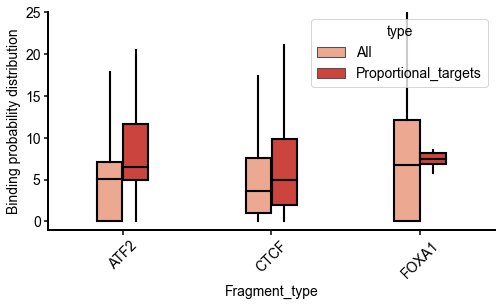

In [9]:
fig, ax = plt.subplots(figsize=(8,4))
sns_ax = sns.boxplot(
    data=plot_df.loc[plot_df.library.isin(["ATF2", "CTCF", "FOXA1"])], x="library", y="binding_prob", hue="type",
    palette=sns.color_palette("Reds", 2).as_hex()[:2],
    orient="v",
    width=0.35,
    linewidth=2.10,
    fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'}, whiskerprops={'color':'k'}, medianprops={'color':'k'}, meanprops={'color':'k'}, # , 'facecolor': 'none'
    ax=ax
    )
ax.spines[["right", "top"]].set_visible(False)
ax.set_ylim((-1., 25))
# ax.set_xlim((-0.5, 9.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Fragment_type")
ax.set_ylabel("Binding probability distribution")

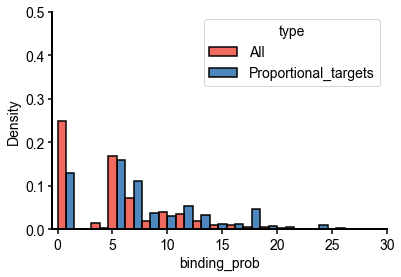

In [15]:
red_color = sns.color_palette("Reds", 10).as_hex()[6]
blue_color = sns.color_palette("Blues", 10).as_hex()[8]
fig, axes = plt.subplots(figsize=(6,4))
sns.histplot(
    plot_df.loc[plot_df.library=="ATF2"], x="binding_prob", hue="type", 
    multiple="dodge", stat="density", bins=75, 
    ax=axes, cumulative=False, common_norm=False, palette=[red_color, blue_color], linewidth=1.5)
axes.set_xlim((-0.5, 30))
axes.set_ylim((0, 0.5))
axes.spines[["right", "top"]].set_visible(False)
# axes.legend(frameon=False)

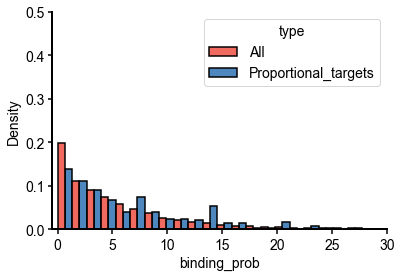

In [13]:
red_color = sns.color_palette("Reds", 10).as_hex()[6]
blue_color = sns.color_palette("Blues", 10).as_hex()[8]
fig, axes = plt.subplots(figsize=(6,4))
sns.histplot(
    plot_df.loc[plot_df.library=="CTCF"], x="binding_prob", hue="type", 
    multiple="dodge", stat="density", bins=75, 
    ax=axes, cumulative=False, common_norm=False, palette=[red_color, blue_color], linewidth=1.5)
axes.set_xlim((-0.5, 30))
axes.set_ylim((0, 0.5))
axes.spines[["right", "top"]].set_visible(False)

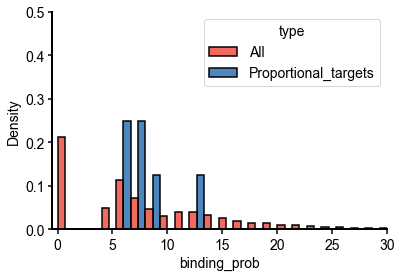

In [14]:
red_color = sns.color_palette("Reds", 10).as_hex()[6]
blue_color = sns.color_palette("Blues", 10).as_hex()[8]
fig, axes = plt.subplots(figsize=(6,4))
sns.histplot(
    plot_df.loc[plot_df.library=="FOXA1"], x="binding_prob", hue="type", 
    multiple="dodge", stat="density", bins=75, 
    ax=axes, cumulative=False, common_norm=False, palette=[red_color, blue_color], linewidth=1.5)
axes.set_xlim((-0.5, 30))
axes.set_ylim((0, 0.5))
axes.spines[["right", "top"]].set_visible(False)

(-7.0, 50.0)

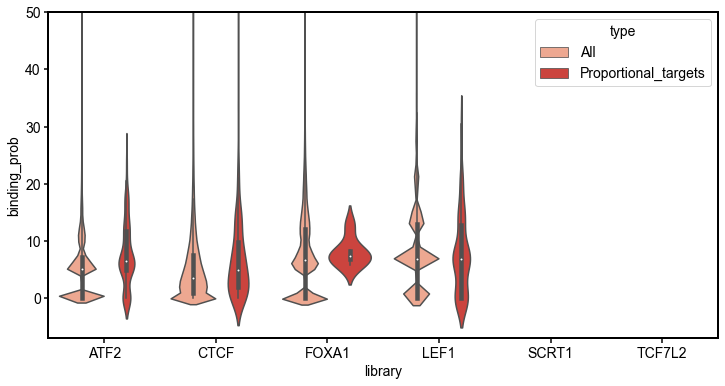

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
sns_ax = sns.violinplot(
    data=plot_df, x="library", y="binding_prob", hue="type",
    palette=sns.color_palette("Reds", 2).as_hex()[:2],
    orient="v",
    # width=0.35,
    # linewidth=2.10,
    # fliersize=0, capprops={'color':'none'}, boxprops={'edgecolor':'k'}, whiskerprops={'color':'k'}, medianprops={'color':'k'}, meanprops={'color':'k'}, # , 'facecolor': 'none'
    ax=ax
    )
ax.set_ylim((-7, 50))

In [23]:
plot_df

,chrom_coord,TF_strand,binding_prob,type
0,chr10_100000046_100000546,ATF2_HUMAN.H11MO.0.B|+,0.000000,all_lib_fragments
1,chr10_100000096_100000555,ATF2_HUMAN.H11MO.0.B|+,0.000000,all_lib_fragments
2,chr10_100005961_100006461,ATF2_HUMAN.H11MO.0.B|+,6.484292,all_lib_fragments
3,chr10_100006011_100006511,ATF2_HUMAN.H11MO.0.B|+,6.484292,all_lib_fragments
4,chr10_100006061_100006561,ATF2_HUMAN.H11MO.0.B|+,6.484292,all_lib_fragments
...,...,...,...,...
1733,chr17_38415514_38416014,ATF2_HUMAN.H11MO.0.B|-,6.590585,all_lib_responsive_fragments_with_targets
1734,chr17_18982209_18982695,ATF2_HUMAN.H11MO.0.B|-,10.064856,all_lib_responsive_fragments_with_targets
1735,chr17_4186921_4187421,ATF2_HUMAN.H11MO.0.B|-,8.946386,all_lib_responsive_fragments_with_targets
1736,chr5_16546711_16547211,ATF2_HUMAN.H11MO.0.B|-,7.211758,all_lib_responsive_fragments_with_targets


In [20]:
merged_lib_response_df.melt(id_vars="chrom_coord", value_vars=tf_cols, var_name="TF_strand", value_name="binding_prob")

,chrom_coord,TF_strand,binding_prob
0,chr7_115731687_115732187,ATF2_HUMAN.H11MO.0.B|+,6.044857
1,chr9_85960583_85961083,ATF2_HUMAN.H11MO.0.B|+,0.000000
2,chr9_132270314_132270814,ATF2_HUMAN.H11MO.0.B|+,0.000000
3,chr10_68153292_68153792,ATF2_HUMAN.H11MO.0.B|+,13.235646
4,chrX_21738387_21738887,ATF2_HUMAN.H11MO.0.B|+,8.931373
...,...,...,...
3577,chr16_85524916_85525416,ATF2_HUMAN.H11MO.0.B|-,12.134074
3578,chr8_46617217_46617717,ATF2_HUMAN.H11MO.0.B|-,5.207512
3579,chr1_233179702_233180202,ATF2_HUMAN.H11MO.0.B|-,0.000000
3580,chr1_222455392_222455885,ATF2_HUMAN.H11MO.0.B|-,10.697872


,chrom_coord,TF_strand,binding_prob
0,chr3_100105778_100106278,ATF2_HUMAN.H11MO.0.B|+,5.125893
1,chr7_104943194_104943694,ATF2_HUMAN.H11MO.0.B|+,0.000000
2,chr7_104943294_104943794,ATF2_HUMAN.H11MO.0.B|+,0.000000
3,chr14_73228629_73229124,ATF2_HUMAN.H11MO.0.B|+,8.461127
4,chr14_73228579_73229079,ATF2_HUMAN.H11MO.0.B|+,8.461127
...,...,...,...
1733,chr17_38415514_38416014,ATF2_HUMAN.H11MO.0.B|-,6.590585
1734,chr17_18982209_18982695,ATF2_HUMAN.H11MO.0.B|-,10.064856
1735,chr17_4186921_4187421,ATF2_HUMAN.H11MO.0.B|-,8.946386
1736,chr5_16546711_16547211,ATF2_HUMAN.H11MO.0.B|-,7.211758


In [8]:
# tf binding probability of all fragments


,PositionID,TF_strand,binding_prob
0,chr10_100000046_100000546,ATF2_HUMAN.H11MO.0.B|+,0.000000
1,chr10_100000096_100000555,ATF2_HUMAN.H11MO.0.B|+,0.000000
2,chr10_100005961_100006461,ATF2_HUMAN.H11MO.0.B|+,6.484292
3,chr10_100006011_100006511,ATF2_HUMAN.H11MO.0.B|+,6.484292
4,chr10_100006061_100006561,ATF2_HUMAN.H11MO.0.B|+,6.484292
...,...,...,...
508317,chrX_9341407_9341907,ATF2_HUMAN.H11MO.0.B|-,5.057207
508318,chrX_9341457_9341957,ATF2_HUMAN.H11MO.0.B|-,5.057207
508319,chrX_9341507_9342007,ATF2_HUMAN.H11MO.0.B|-,5.057207
508320,chrX_9341557_9342057,ATF2_HUMAN.H11MO.0.B|-,5.057207


In [44]:
lib_df

,chrom_coord,gene_name,CC_act,CC_exp,CC_peak,ATF2_log2FoldChange_act,ATF2_log2FoldChange_exp,ATF2_peak,ATF2_act,ATF2_padj_act,ATF2_padj_exp,distance
0,chr3_100105778_100106278,CMSS1,4.234542,2.087819,1,-2.135866,-0.518864,1,2.184595,4.065076e-46,4.440584e-30,0
1,chr7_104943194_104943694,KMT2E,1.172121,3.085249,1,-0.933463,-0.586712,0,0.332994,5.031115e-07,1.643039e-17,0
2,chr7_104943294_104943794,KMT2E,1.125188,3.085249,1,-0.824755,-0.586712,0,0.392522,2.225131e-05,1.643039e-17,0
3,chr14_73228629_73229124,PSEN1,0.673837,6.020567,0,0.982045,0.177482,1,1.737797,6.406835e-05,2.556446e-07,4939
4,chr14_73228579_73229079,PSEN1,0.986337,6.020567,0,1.050389,0.177482,1,2.112589,2.475936e-05,2.556446e-07,4889
...,...,...,...,...,...,...,...,...,...,...,...,...
864,chr17_38415514_38416014,ARHGAP23,3.818660,0.193795,1,-0.961011,3.313369,1,2.885657,1.174971e-02,1.631928e-206,3267
865,chr17_18982209_18982695,FAM83G,2.393601,3.158040,1,-0.664387,2.328402,0,1.785328,2.373696e-02,6.761355e-205,0
866,chr17_4186921_4187421,ANKFY1,2.811621,8.282389,1,-0.851256,0.241977,1,2.027927,2.536042e-03,7.295861e-04,0
867,chr5_16546711_16547211,RETREG1,2.038412,0.645232,1,-1.094604,0.885603,0,1.019440,2.218635e-05,3.696691e-36,0


In [45]:
mean_tf_val = min(motif_df.loc[:, tf_cols].mean())
tf_query = "|".join([f"`{tf_col}`>{mean_tf_val}" for tf_col in tf_cols])
merged_df.query(tf_query).loc[:, list(lib_df.columns) + tf_cols]

,chrom_coord,gene_name,CC_act,CC_exp,CC_peak,ATF2_log2FoldChange_act,ATF2_log2FoldChange_exp,ATF2_peak,ATF2_act,ATF2_padj_act,ATF2_padj_exp,distance,ATF2_HUMAN.H11MO.0.B|+,ATF2_HUMAN.H11MO.0.B|-
0,chr3_100105778_100106278,CMSS1,4.234542,2.087819,1,-2.135866,-0.518864,1,2.184595,4.065076e-46,4.440584e-30,0,5.125893,0.000000
1,chr7_104943194_104943694,KMT2E,1.172121,3.085249,1,-0.933463,-0.586712,0,0.332994,5.031115e-07,1.643039e-17,0,0.000000,6.979041
3,chr14_73228629_73229124,PSEN1,0.673837,6.020567,0,0.982045,0.177482,1,1.737797,6.406835e-05,2.556446e-07,4939,8.461127,7.644225
4,chr14_73228579_73229079,PSEN1,0.986337,6.020567,0,1.050389,0.177482,1,2.112589,2.475936e-05,2.556446e-07,4889,8.461127,7.644225
5,chr14_73228279_73228779,PSEN1,1.279566,6.020567,0,1.147857,0.177482,1,2.494181,3.544890e-05,2.556446e-07,4589,8.461127,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,chr17_38415514_38416014,ARHGAP23,3.818660,0.193795,1,-0.961011,3.313369,1,2.885657,1.174971e-02,1.631928e-206,3267,0.000000,6.590585
865,chr17_18982209_18982695,FAM83G,2.393601,3.158040,1,-0.664387,2.328402,0,1.785328,2.373696e-02,6.761355e-205,0,13.002292,10.064856
866,chr17_4186921_4187421,ANKFY1,2.811621,8.282389,1,-0.851256,0.241977,1,2.027927,2.536042e-03,7.295861e-04,0,5.919549,8.946386
867,chr5_16546711_16547211,RETREG1,2.038412,0.645232,1,-1.094604,0.885603,0,1.019440,2.218635e-05,3.696691e-36,0,9.310848,7.211758


In [37]:
motif_df.loc[:, tf_cols].describe()

,ATF2_HUMAN.H11MO.0.B|+,ATF2_HUMAN.H11MO.0.B|-
count,254161.000000,254161.000000
mean,3.245960,3.175350
std,4.537716,4.472432
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,5.669475,5.593036
max,115.439154,63.372362


In [35]:
merged_df.loc[:, tf_cols].describe()

,ATF2_HUMAN.H11MO.0.B|+,ATF2_HUMAN.H11MO.0.B|-
count,94.000000,94.000000
mean,8.268066,5.758619
std,6.727548,4.099317
min,0.000000,0.000000
25%,0.000000,4.831776
50%,6.472382,5.734968
75%,16.101764,6.315523
max,17.345461,19.643365
